In [1]:
%%capture
!git clone https://github.com/Cho-D-YoungRae/URP-PedestrianDetection.git
%cd URP-PedestrianDetection

In [2]:
import dataset
import object_detection
from utils import *

import os
import argparse
from PIL import Image
import numpy as np
import json

from torchvision.transforms import functional as TF
from torch.nn.functional import interpolate
import torch
import torchvision.transforms
import torch.nn.functional as F

data_dir = '/content/drive/MyDrive/2021.summer_URP/PD/KAIST_PD'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using <{device}> device")

Using <cpu> device


In [3]:
# ====== constants ======#
label_map = {'background': 0, 'person': 1}
rev_label_map = {v: k for k, v in label_map.items()} 

## setting

In [4]:
from torch.backends import cudnn
import random

cudnn.benchmark = True

# ====== Random Seed Initialization ====== #
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.baselineID = 30

# ====== Dataset ====== #
args.ch_option = {'num_ch': 1,
                  'img_type': 'lwir',
                  'one_ch_option': 'mean'}

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
if args.ch_option.get('num_ch') == 1:
    if args.ch_option.get('one_ch_option') == 'mean':
        mean = sum(mean) / len(mean)
        std = sum(std) / len(std)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(300,300)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

In [6]:
checkpoint_dir = '/content/drive/MyDrive/2021.summer_URP/PD/checkpoint'
checkpoint_path = os.path.join(checkpoint_dir,
                               str(args.baselineID)+'.pth.tar')

checkpoint = torch.load(checkpoint_path, map_location=device)
save_epoch = checkpoint['epoch']
print(f'Loaded checkpoint from epoch {save_epoch}\n')
model = checkpoint['model']
model = model.eval()

Loaded checkpoint from epoch 150



In [7]:
def normalize_ftmap(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [8]:
def get_feature_idx(ft_name: str) -> (int, int):
    conv_idx = [0, 5776, 7942, 8542, 8692, 8728, 8732]
    name2idx = {'conv4_3': 0, 'conv7': 1, 'conv8_2': 2,
                'conv9_2': 3, 'conv10_2': 4, 'conv11_2': 5}
    start_idx = name2idx[ft_name]
    start_idx = conv_idx[start_idx]
    end_idx = name2idx[ft_name] + 1
    end_idx = conv_idx[end_idx]

    return start_idx, end_idx

In [9]:
def get_confidence_img(ft_name: str):
    start_idx, end_idx = get_feature_idx(ft_name)
    confidence = classes_scores[:, start_idx: end_idx, :].detach()
    fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10,
                 'conv9_2': 5, 'conv10_2': 3, 'conv11_2': 1}
    fmap_dim = fmap_dims[ft_name]
    n_boxes = {'conv4_3': 4, 'conv7': 6, 'conv8_2': 6,
               'conv9_2': 6, 'conv10_2': 4, 'conv11_2': 4}
    n_box = n_boxes[ft_name]
    confidence = confidence.view(1, fmap_dim, fmap_dim, n_box, 2)[:,:,:,:,1]
    confidence = torch.mean(confidence, dim=3)
    confidence = interpolate(confidence.unsqueeze(0),
                             size=img_size, mode='nearest')
    confidence = normalize_ftmap(confidence[0])
    return TF.to_pil_image(confidence)

# set08/V001/I02119


## Image init

In [10]:
img_id = 'set08/V001/I02119'
ann_path = os.path.join(data_dir, 'annotation_json', img_id+'.json')
img_dir, img_name = os.path.split(img_id)
img_path = os.path.join(data_dir, 'images', img_dir, 'lwir', img_name+'.jpg')

In [11]:
with open(ann_path, 'r') as j:
    anns = json.load(j)

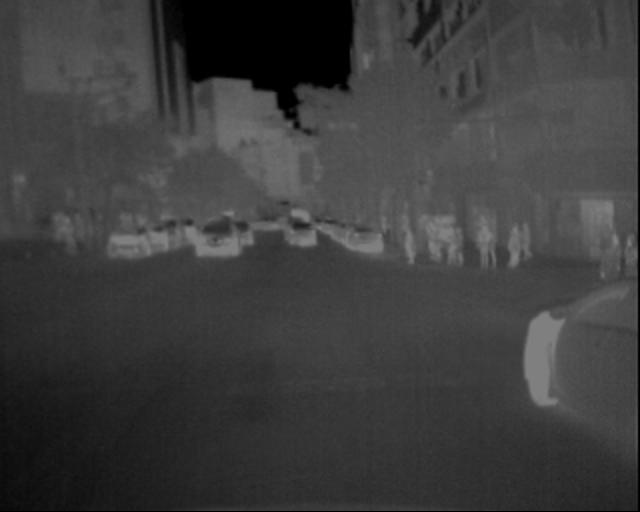

In [12]:
image = Image.open(img_path).convert('L')
img_size = (image.height, image.width)
image

In [13]:
img_size = (image.height, image.width)
pseudo_gt = torch.zeros(img_size)
for ann in anns['annotation']:
    x_min, y_min, x_max, y_max = ann['bbox']
    pseudo_gt[y_min:y_max+1, x_min:x_max+1] = 1

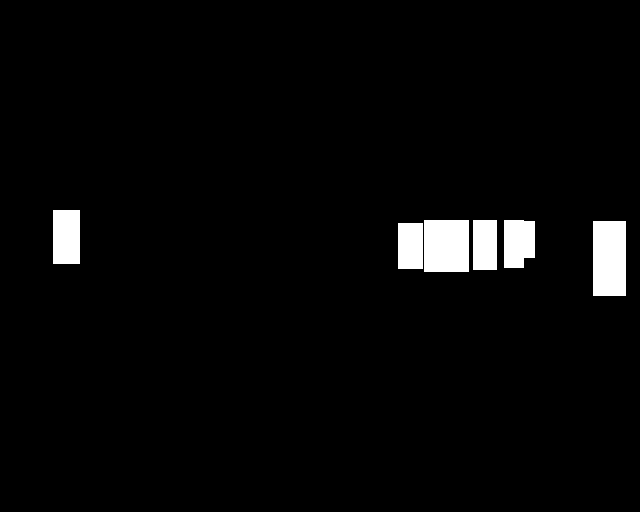

In [14]:
TF.to_pil_image(pseudo_gt)

## feature map visualization

In [15]:
input = preprocess(image)
conv4_3_feats, conv7_feats = model.base(input.unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


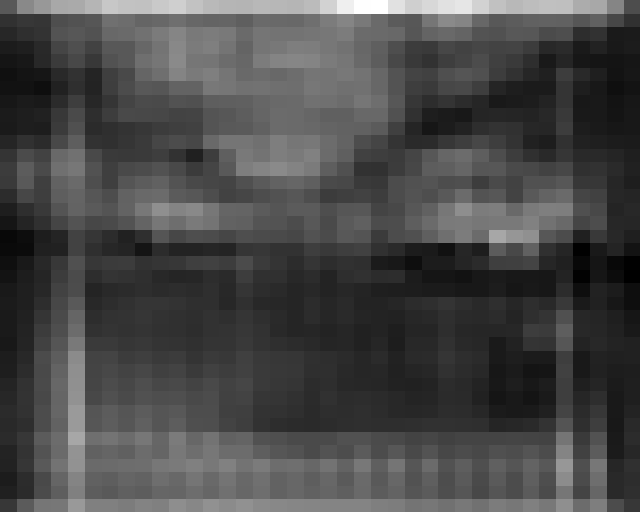

In [16]:
ftmap_v = torch.mean(conv4_3_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

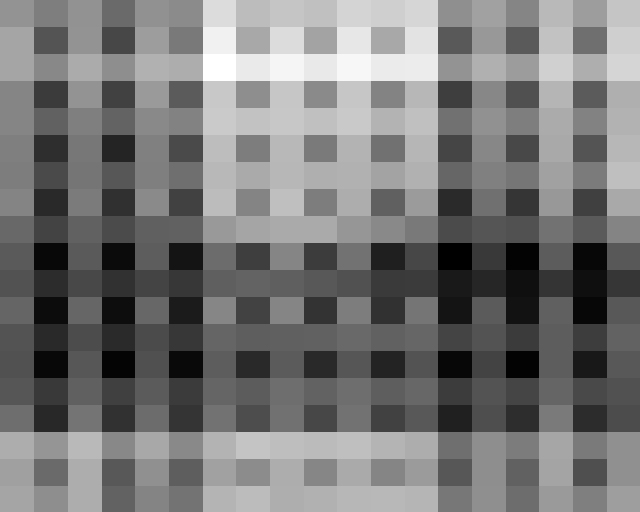

In [17]:
ftmap_v = torch.mean(conv7_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

## region proposal visualization

In [18]:
input = preprocess(image)
locs, classes_scores = model(input.unsqueeze(0))
print(classes_scores.size())

torch.Size([1, 8732, 2])


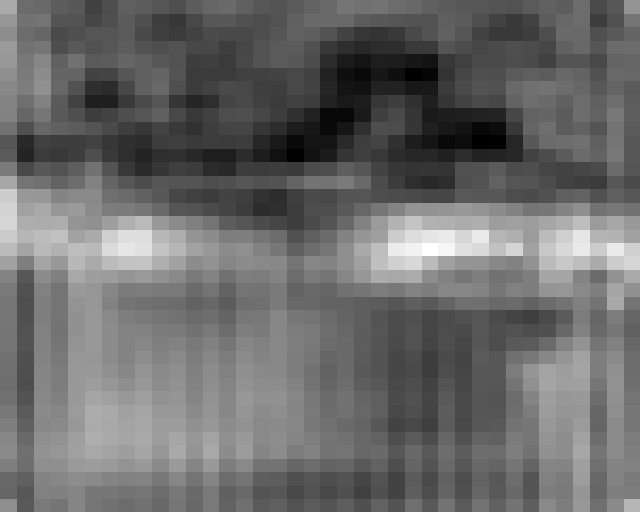

In [19]:
get_confidence_img('conv4_3')

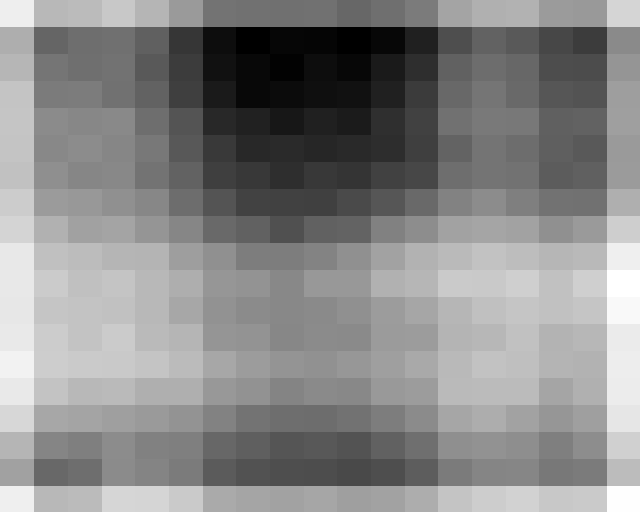

In [20]:
get_confidence_img('conv7')

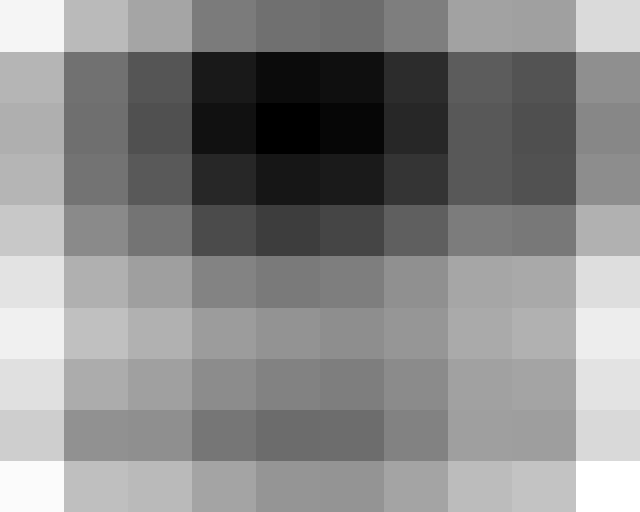

In [21]:
get_confidence_img('conv8_2')

# set08/V000/I01679


## Image init

In [22]:
img_id = 'set08/V000/I01679'
ann_path = os.path.join(data_dir, 'annotation_json', img_id+'.json')
img_dir, img_name = os.path.split(img_id)
img_path = os.path.join(data_dir, 'images', img_dir, 'lwir', img_name+'.jpg')

In [23]:
with open(ann_path, 'r') as j:
    anns = json.load(j)

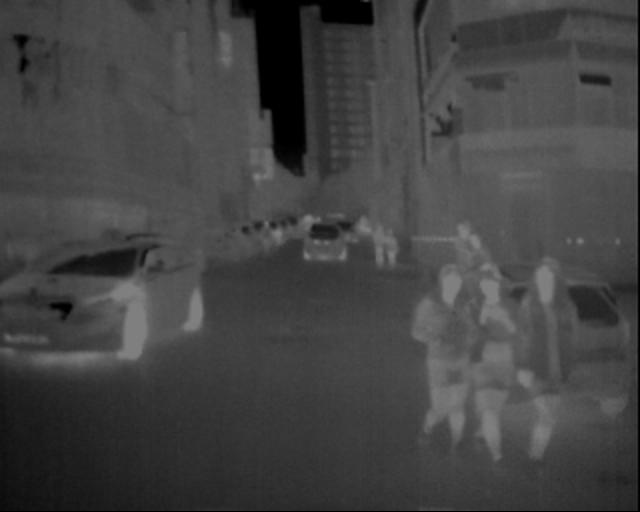

In [24]:
image = Image.open(img_path).convert('L')
img_size = (image.height, image.width)
image

In [25]:
img_size = (image.height, image.width)
pseudo_gt = torch.zeros(img_size)
for ann in anns['annotation']:
    x_min, y_min, x_max, y_max = ann['bbox']
    pseudo_gt[y_min:y_max+1, x_min:x_max+1] = 1

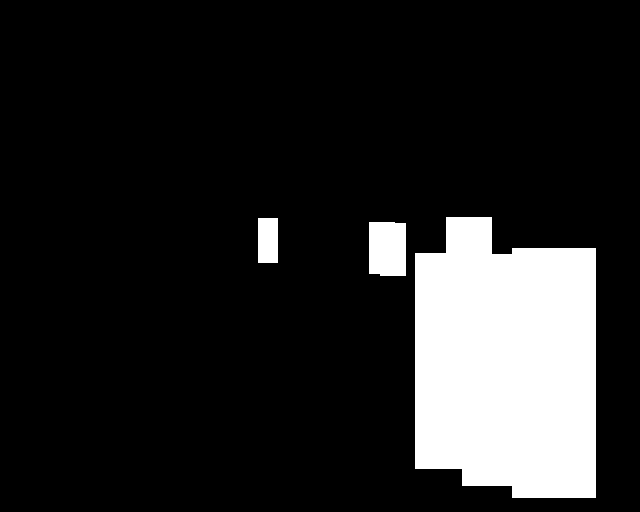

In [26]:
TF.to_pil_image(pseudo_gt)

## feature map visualization

In [27]:
input = preprocess(image)
conv4_3_feats, conv7_feats = model.base(input.unsqueeze(0))

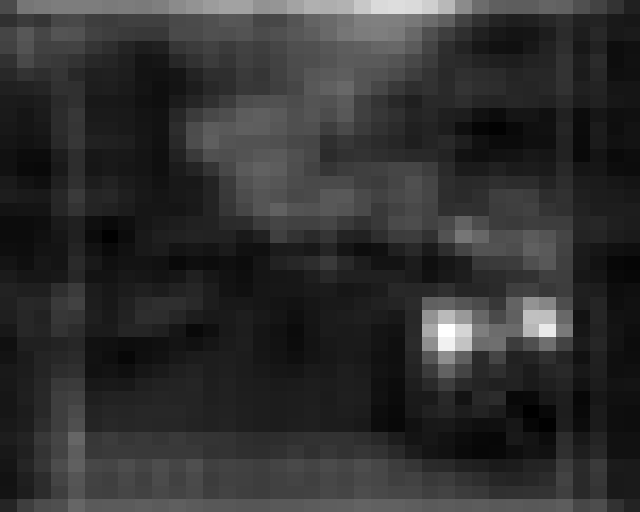

In [28]:
ftmap_v = torch.mean(conv4_3_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

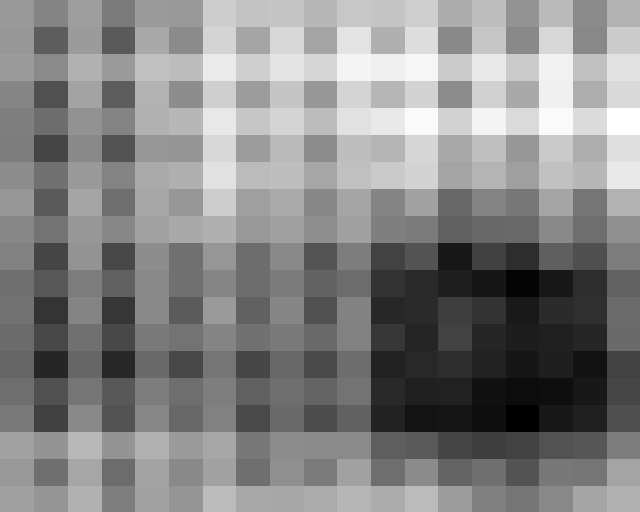

In [29]:
ftmap_v = torch.mean(conv7_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

## region proposal visualization

In [30]:
input = preprocess(image)
locs, classes_scores = model(input.unsqueeze(0))
print(classes_scores.size())

torch.Size([1, 8732, 2])


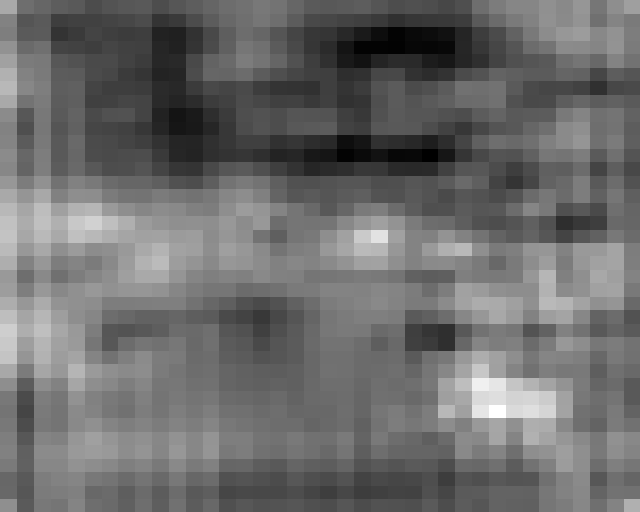

In [31]:
get_confidence_img('conv4_3')

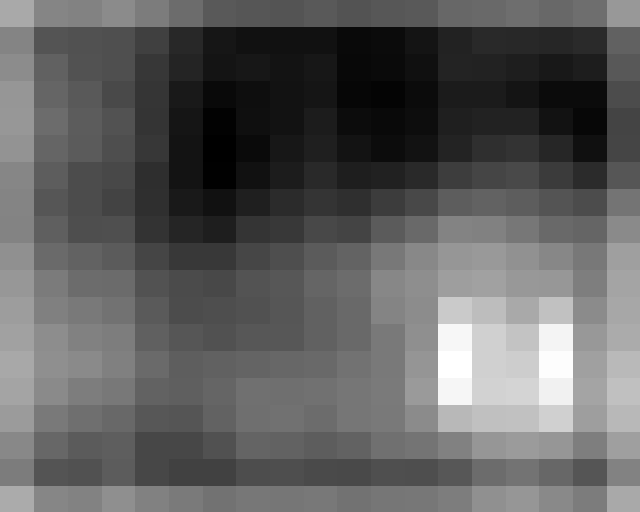

In [32]:
get_confidence_img('conv7')

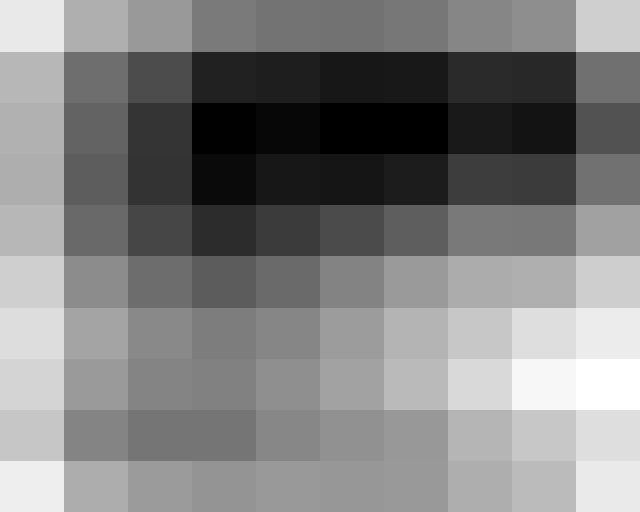

In [33]:
get_confidence_img('conv8_2')

# set08/V001/I02659


## Image init

In [34]:
img_id = 'set08/V001/I02659'
ann_path = os.path.join(data_dir, 'annotation_json', img_id+'.json')
img_dir, img_name = os.path.split(img_id)
img_path = os.path.join(data_dir, 'images', img_dir, 'lwir', img_name+'.jpg')

In [35]:
with open(ann_path, 'r') as j:
    anns = json.load(j)

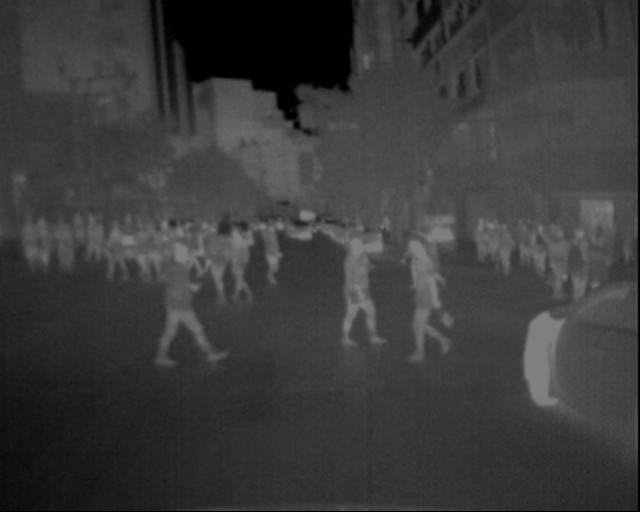

In [36]:
image = Image.open(img_path).convert('L')
img_size = (image.height, image.width)
image

In [37]:
img_size = (image.height, image.width)
pseudo_gt = torch.zeros(img_size)
for ann in anns['annotation']:
    x_min, y_min, x_max, y_max = ann['bbox']
    pseudo_gt[y_min:y_max+1, x_min:x_max+1] = 1

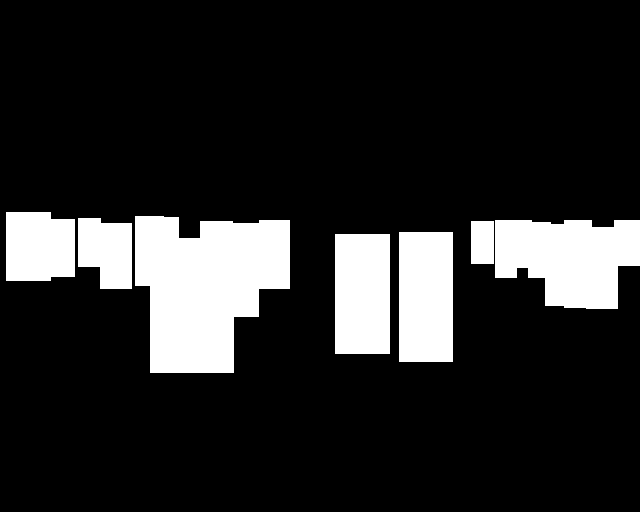

In [38]:
TF.to_pil_image(pseudo_gt)

## feature map visualization

In [39]:
input = preprocess(image)
conv4_3_feats, conv7_feats = model.base(input.unsqueeze(0))

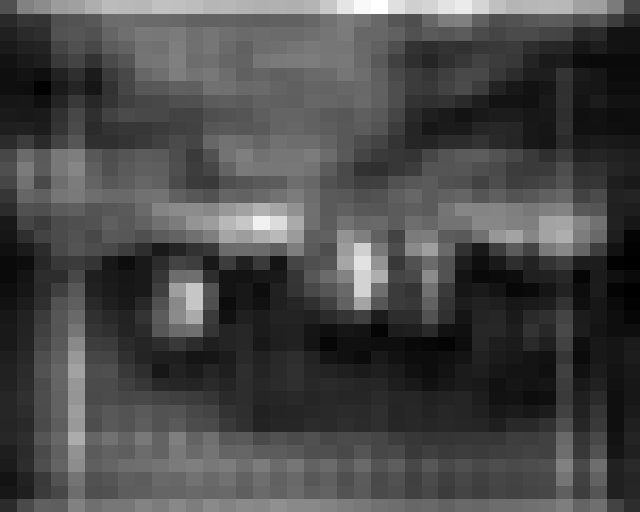

In [40]:
ftmap_v = torch.mean(conv4_3_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

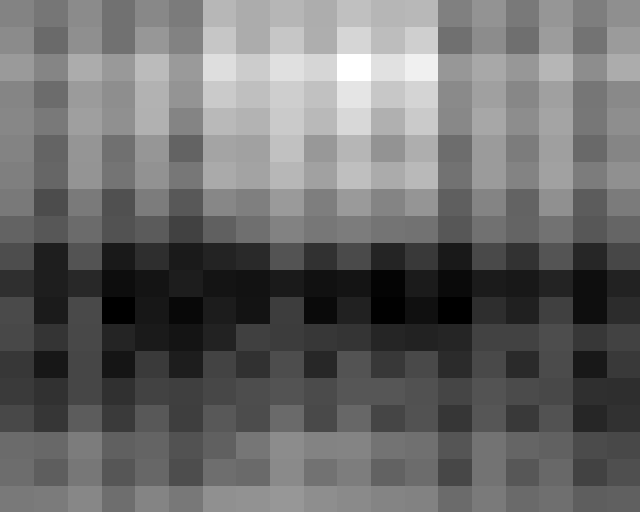

In [41]:
ftmap_v = torch.mean(conv7_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

## region proposal visualization

In [42]:
input = preprocess(image)
locs, classes_scores = model(input.unsqueeze(0))
print(classes_scores.size())

torch.Size([1, 8732, 2])


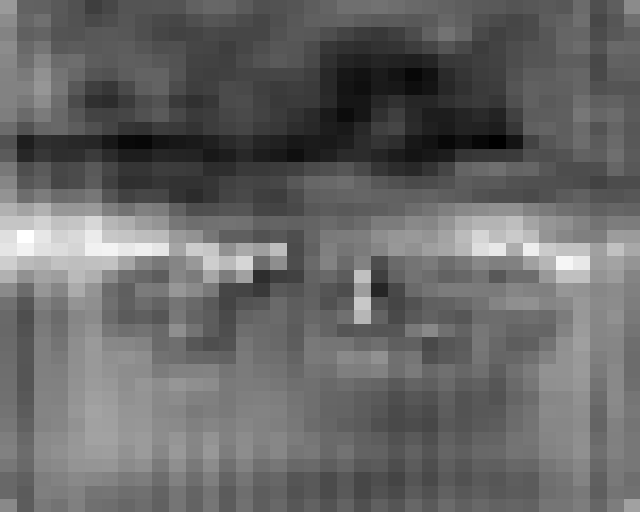

In [43]:
get_confidence_img('conv4_3')

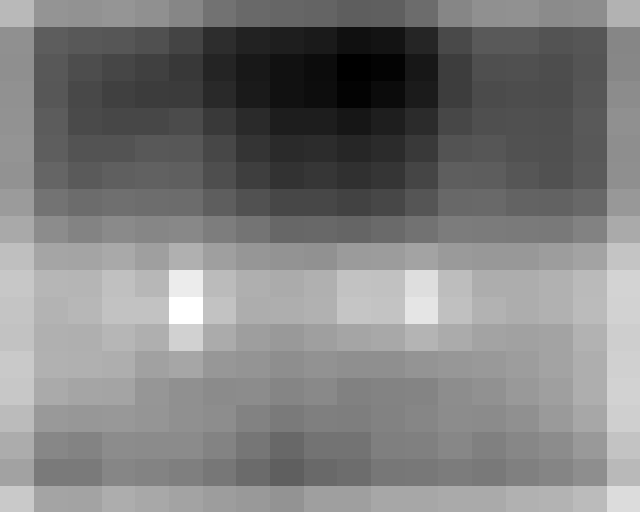

In [44]:
get_confidence_img('conv7')

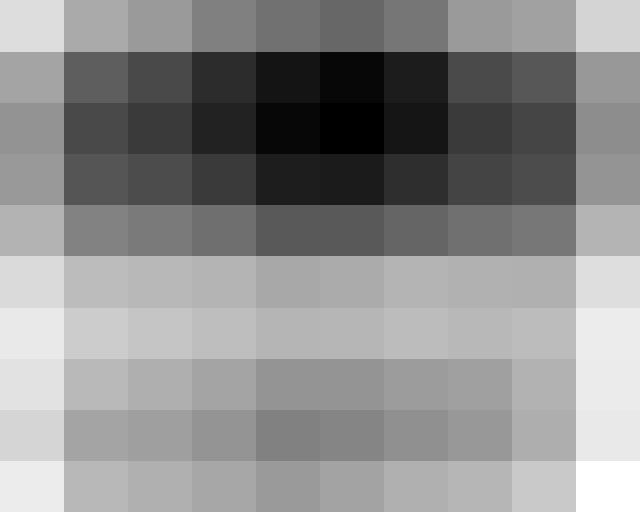

In [45]:
get_confidence_img('conv8_2')

# set01/V001/I00063


## Image init

In [46]:
img_id = 'set01/V001/I00063'
ann_path = os.path.join(data_dir, 'annotation_json', img_id+'.json')
img_dir, img_name = os.path.split(img_id)
img_path = os.path.join(data_dir, 'images', img_dir, 'lwir', img_name+'.jpg')

In [47]:
with open(ann_path, 'r') as j:
    anns = json.load(j)

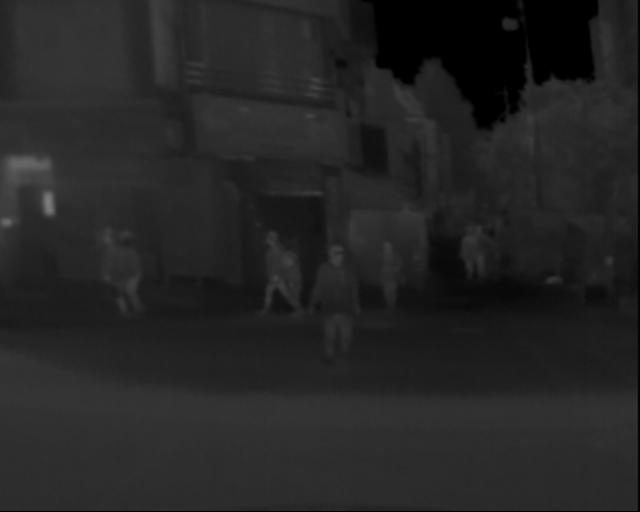

In [48]:
image = Image.open(img_path).convert('L')
img_size = (image.height, image.width)
image

In [49]:
img_size = (image.height, image.width)
pseudo_gt = torch.zeros(img_size)
for ann in anns['annotation']:
    x_min, y_min, x_max, y_max = ann['bbox']
    pseudo_gt[y_min:y_max+1, x_min:x_max+1] = 1

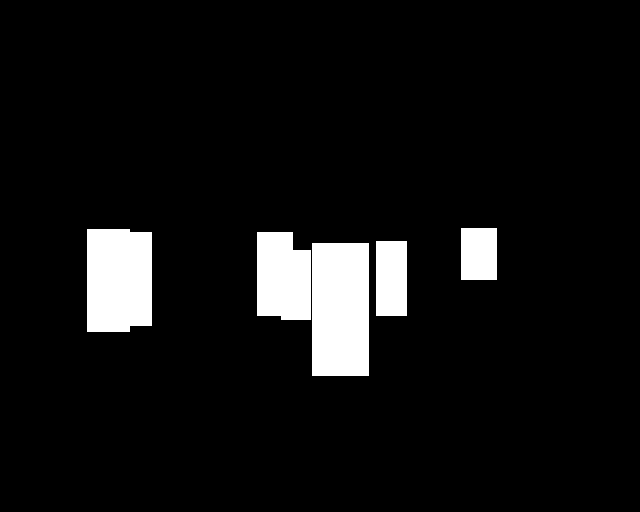

In [50]:
TF.to_pil_image(pseudo_gt)

## feature map visualization

In [51]:
def normalize_ftmap(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [52]:
input = preprocess(image)
conv4_3_feats, conv7_feats = model.base(input.unsqueeze(0))

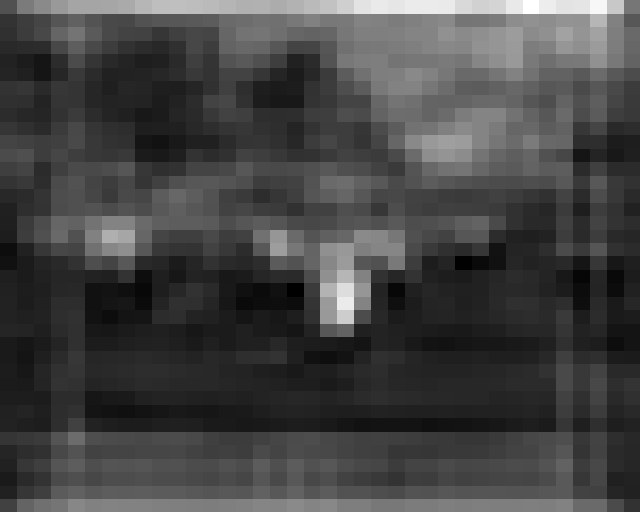

In [53]:
ftmap_v = torch.mean(conv4_3_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

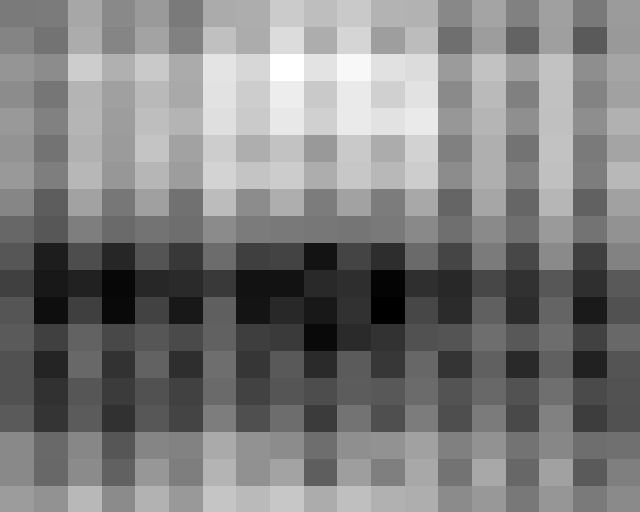

In [54]:
ftmap_v = torch.mean(conv7_feats.detach(), dim=1, keepdim=True)
ftmap_v = interpolate(ftmap_v, size=img_size, mode='nearest')
ftmap_v = normalize_ftmap(ftmap_v[0])
TF.to_pil_image(ftmap_v)

## region proposal visualization

In [55]:
input = preprocess(image)
locs, classes_scores = model(input.unsqueeze(0))
print(classes_scores.size())

torch.Size([1, 8732, 2])


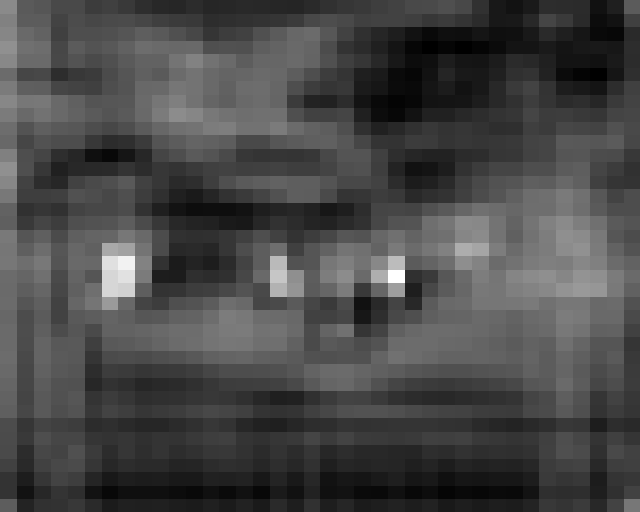

In [56]:
get_confidence_img('conv4_3')

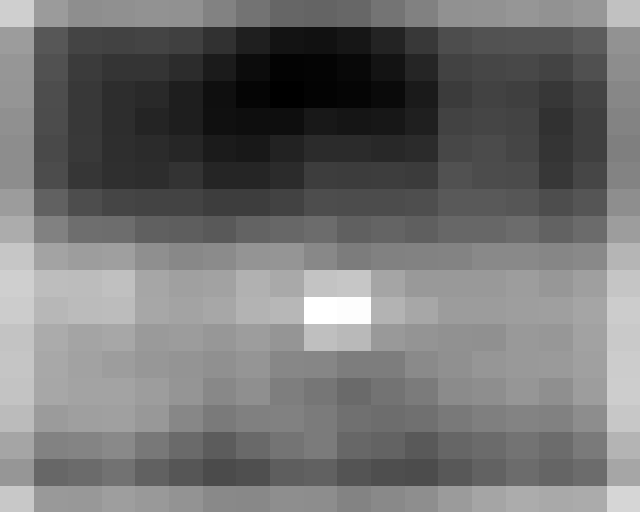

In [57]:
get_confidence_img('conv7')

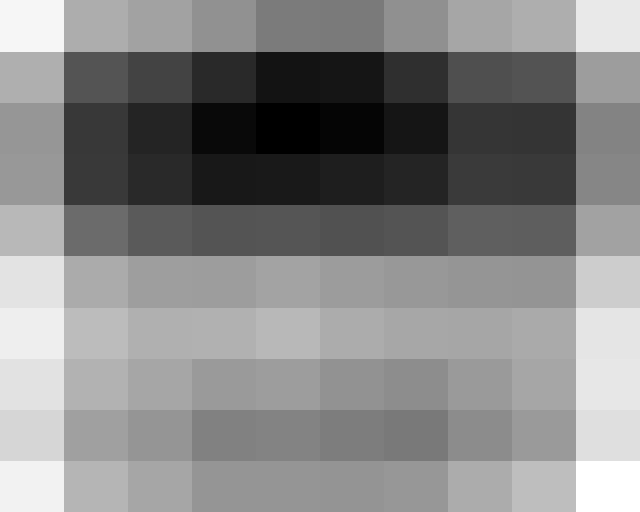

In [58]:
get_confidence_img('conv8_2')